In [ ]:
# RNN(Recurrent Nerual Network)
# RNN - LSTM Long Short - Term Memory
# 곱셉을 이용하는 것보다 덧셈을이용해서 과거의 값을 처리하는 것이 유리함

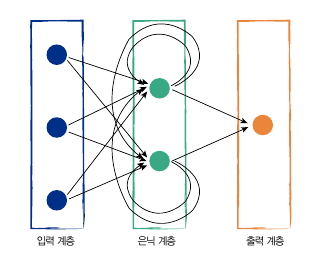

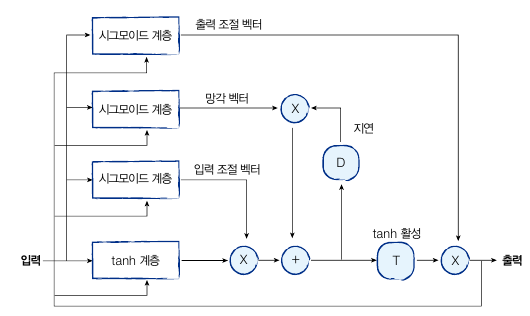

In [20]:
from tensorflow.keras.preprocessing import sequence

In [21]:
from tensorflow.keras.datasets import imdb

In [22]:
from tensorflow.keras import layers, models

In [23]:
# IMDB 1 추천   0 비추천   25000

In [24]:
class Data:
  def __init__(self,max_features = 20000, maxlen = 80) -> None:
    (self.x_train, self.y_train),(self.x_test, self.y_test) = imdb.load_data(num_words=max_features)
    # 문장의 길이가 서로 다르므로 길이를 통일
    self.x_train = sequence.pad_sequences(self.x_train, maxlen = maxlen)
    self.x_test = sequence.pad_sequences(self.x_test, maxlen = maxlen)

In [25]:
class RnnLstm(models.Model):
  def __init__(self, max_features=20000, maxlen=80):
    inputs = layers.Input((maxlen,))
    x = layers.Embedding(max_features, 128)(inputs)
    x = layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2)(x)
    outputs = layers.Dense(1,activation='sigmoid')(x)
    super().__init__(inputs, outputs)
    self.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])

In [26]:
# 학습, 성능평가 클래스  
class Machine:
  def __init__(self,max_features=20000, maxlen=80) -> None:
    self.data = Data(max_features,maxlen)
    self.model = RnnLstm(max_features,maxlen)
  def run(self, epochs=3, batch_size=32):
    data = self.data
    model = self.model
    model.fit(data.x_train,data.y_train,batch_size=batch_size, epochs = epochs
              ,validation_data = (data.x_test,data.y_test))
    loss,acc =  model.evaluate(data.x_test, data.y_test, batch_size=batch_size)
    print(f"loss:{loss:.4f}  accuracy:{acc}")


In [27]:
m = Machine()
m.run()

Epoch 1/3
782/782 [==============================] - 247s 311ms/step - loss: 0.4267 - acc: 0.8016 - val_loss: 0.3708 - val_acc: 0.8398
Epoch 2/3
782/782 [==============================] - 244s 312ms/step - loss: 0.2616 - acc: 0.8948 - val_loss: 0.3806 - val_acc: 0.8398
Epoch 3/3
782/782 [==============================] - 29s 37ms/step - loss: 0.4353 - acc: 0.8284
loss:0.4353  accuracy:0.8283600211143494


In [ ]:
# word2vec 
# 단어 입력이 주어지면 스킵-그랩 을 사용해서 문맥을 예측하는 모델을 학습
# Our company provides smart agirculture solutons .....

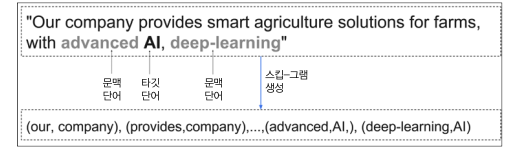

In [28]:
import os
import math
import numpy as np
import tensorflow as tf

In [29]:
batch_size = 64
embedding_dimension = 5
nagative_samples = 8
LOG_DIR = '/content/sample_data'


In [32]:
digit_to_word_map = dict(zip(range(1,10),['one','two','three','four','five','six','seven','eight','nine'] ))
word_to_digi_map = dict(zip(['one','two','three','four','five','six','seven','eight','nine'],range(1,10) ))

In [73]:
# 홀수 시퀀스 / 짝수 시퀀스 두 종류의 문장
seq = []
for i in range(10000):
  rand_odds =  np.random.choice(range(1,10,2),3)
  seq.append( " ".join([digit_to_word_map[r] for r in  rand_odds]))
  rand_even =  np.random.choice(range(2,10,2),3)
  seq.append( " ".join([digit_to_word_map[r] for r in  rand_even]))

In [74]:
seq[:10]

['one five three',
 'four six eight',
 'one five nine',
 'six two two',
 'one three three',
 'four six eight',
 'nine seven one',
 'two eight two',
 'seven nine seven',
 'eight six two']

In [75]:
word2index_map ={}
index = 0
for i in seq:
  for word in i.lower().split():
    if word not in word2index_map:
      word2index_map[word] = index
      index += 1      

In [76]:
index2word_map =  {index:word for word, index in  word2index_map.items()}
vocabulary_size = len(index2word_map)

In [77]:
# word2vector 준비단계로 스킵-그랩을 생성

In [78]:
skip_gram_pairs = []
for sent in seq:
  tokenized_sent = sent.lower().split()  
  for i in range(1, len(tokenized_sent)-1):
    word_context_pair = [
        [
        word2index_map[tokenized_sent[i-1]],
        word2index_map[tokenized_sent[i+1]]
        ],
        word2index_map[tokenized_sent[i]]
    ]
    
    skip_gram_pairs.append(
        [
            word_context_pair[1],
            word_context_pair[0][0]
        ]      
    )
    skip_gram_pairs.append(
        [
            word_context_pair[1],
            word_context_pair[0][1]
        ]
    )


In [79]:
# 배치형태로 
def get_skipgram_batch(batch_size):
  instance_indeces =  list(range(len(skip_gram_pairs)))
  np.random.shuffle(instance_indeces)
  batch = instance_indeces[:batch_size]
  x = [skip_gram_pairs[i][1] for i in batch]
  y = [[skip_gram_pairs[i][0]] for i in batch]
  return x,y

In [80]:
x_batch, y_batch =  get_skipgram_batch(8)
x_batch, y_batch

([4, 5, 2, 1, 6, 6, 8, 8], [[5], [7], [1], [2], [1], [0], [2], [8]])

In [81]:
[index2word_map[word] for word in x_batch]

['six', 'eight', 'three', 'five', 'nine', 'nine', 'seven', 'seven']

In [82]:
[index2word_map[word[0]] for word in y_batch]

['eight', 'two', 'five', 'three', 'five', 'one', 'three', 'seven']

In [87]:
# 입력데이터 레이블
import tensorflow as tf
batch_size

64

In [96]:
with tf.compat.v1.Session() as sess:
  train_inputs = tf.compat.v1.placeholder(tf.int32, shape = (batch_size))
  train_labels = tf.compat.v1.placeholder(tf.int32, shape = (batch_size,1))

<tf.Tensor 'Placeholder_4:0' shape=(64, 1) dtype=int32>

In [ ]:
help(tf.compat.v1.placeholder)

In [93]:
with tf.compat.v1.Session() as sess:
  x = tf.compat.v1.placeholder(tf.float32, shape=(1024, 1024))